In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import os

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
path = Path('data/chest_xray/')
path_hr = Path('data/chest_xray/images')
path_lr = Path('data/chest_xray/crappy')
path_reverse = Path('data/chest_xray/pred_reverse')
path_pred = Path('data/chest_xray/gan_pred')

In [5]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [6]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform( size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
bs,size=12,256
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [8]:
data_gen = get_data(bs,size)

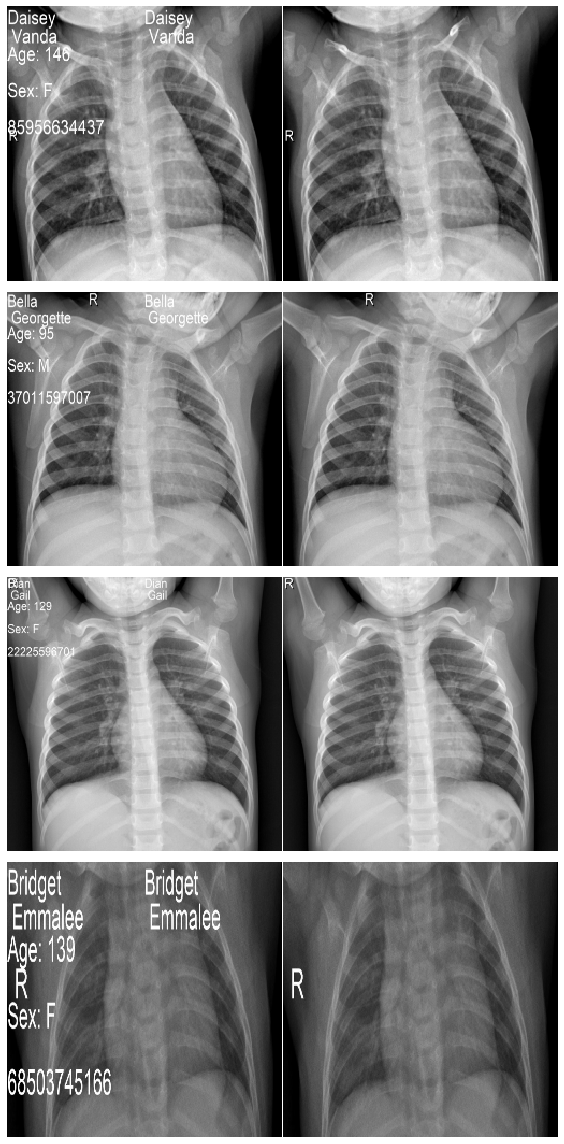

In [9]:
data_gen.show_batch(4)

In [9]:
wd = 1e-3

In [10]:
y_range = (-3.,3.)

In [11]:
loss_gen = MSELossFlat()

In [12]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [13]:
learn_gen = create_gen_learner()

In [15]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [16]:
learn_gen.unfreeze()

In [17]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

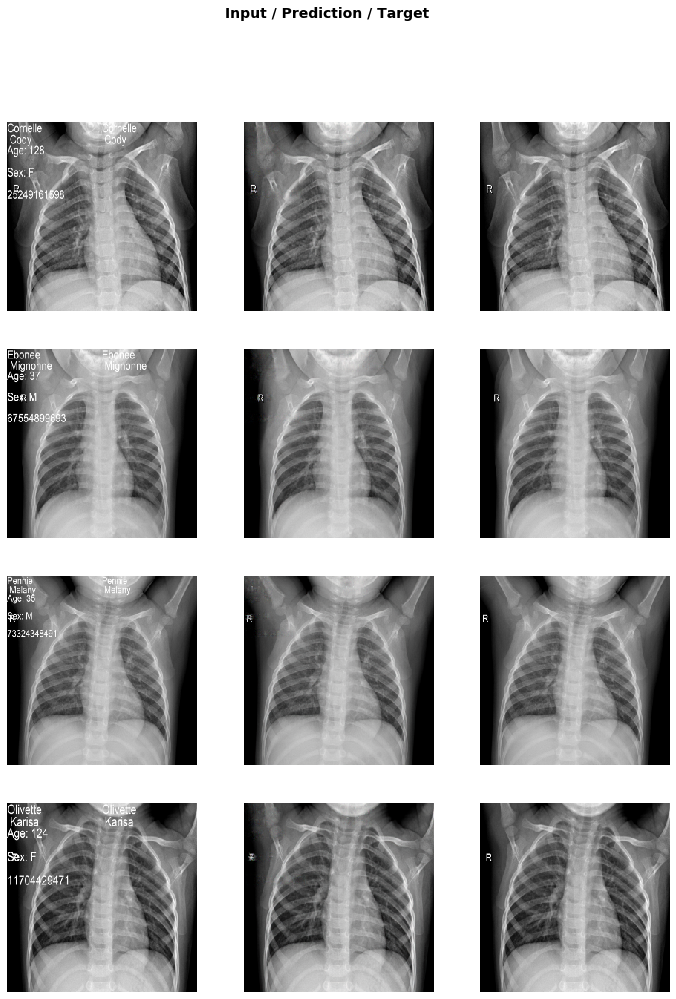

In [18]:
learn_gen.show_results(rows=4)

In [19]:
learn_gen.save('gen-pre2')

In [14]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (1425 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/chest_xray/crappy;

Valid: LabelList (158 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/chest_xray/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Seque

In [15]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [22]:
path_gen.mkdir(exist_ok=True)

In [23]:
save_preds(data_gen.fix_dl)

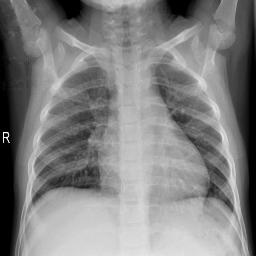

In [24]:
PIL.Image.open(path_gen.ls()[0])

In [16]:
learn_gen=None
gc.collect()

180

In [17]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 2
    return data

In [18]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

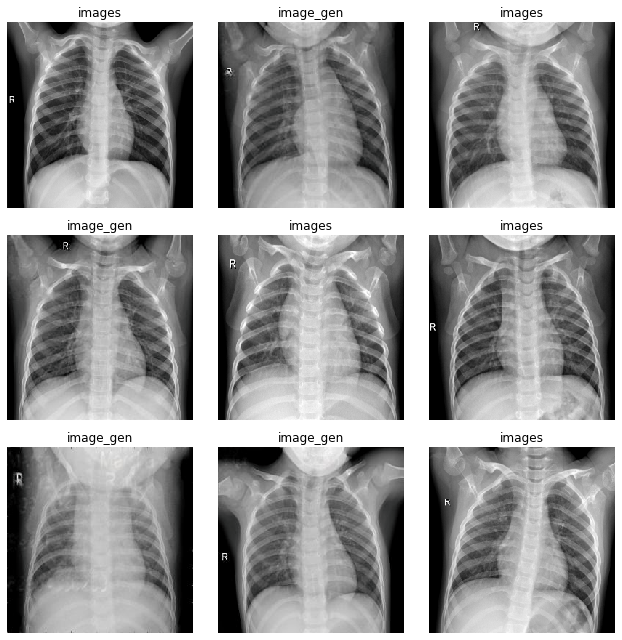

In [28]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [19]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [20]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [21]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 2.75E-05


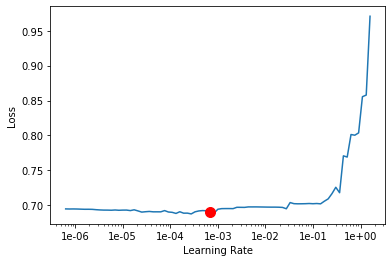

In [32]:
#learn_critic.unfreeze()
learn_critic.lr_find()
learn_critic.recorder.plot(suggestion=True)

In [33]:
learn_critic.fit_one_cycle(6, learn_critic.recorder.min_grad_lr)

In [34]:
learn_critic.save('critic-pre2')

In [22]:
learn_crit=None
learn_gen=None
gc.collect()

27

In [23]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

In [24]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [25]:
learn_gen = create_gen_learner().load('gen-pre2')

In [26]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.91E-05


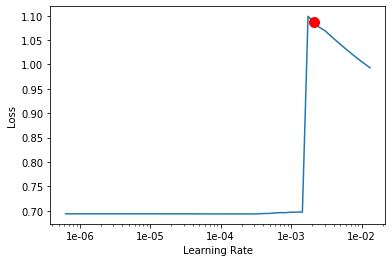

In [28]:
learn.recorder.plot(suggestion=True)

In [29]:
lr = learn.recorder.min_grad_lr

In [43]:
learn.fit(40, lr)

In [44]:
learn.save('gan-1c')

In [30]:
#learn=None
gc.collect()

6576

In [31]:
learn.load('gan-1c')

GANLearner(data=ImageDataBunch;

Train: LabelList (1425 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/chest_xray/crappy;

Valid: LabelList (158 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: data/chest_xray/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dila

In [32]:
learn.data=get_data(3,400)

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


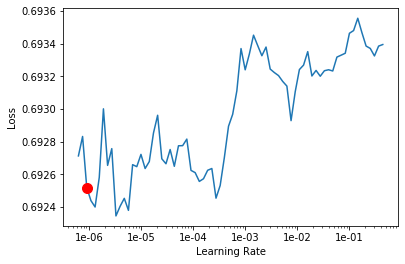

In [38]:
learn.recorder.plot(suggestion=True)

In [39]:
learn.fit(10,learn.recorder.min_grad_lr)

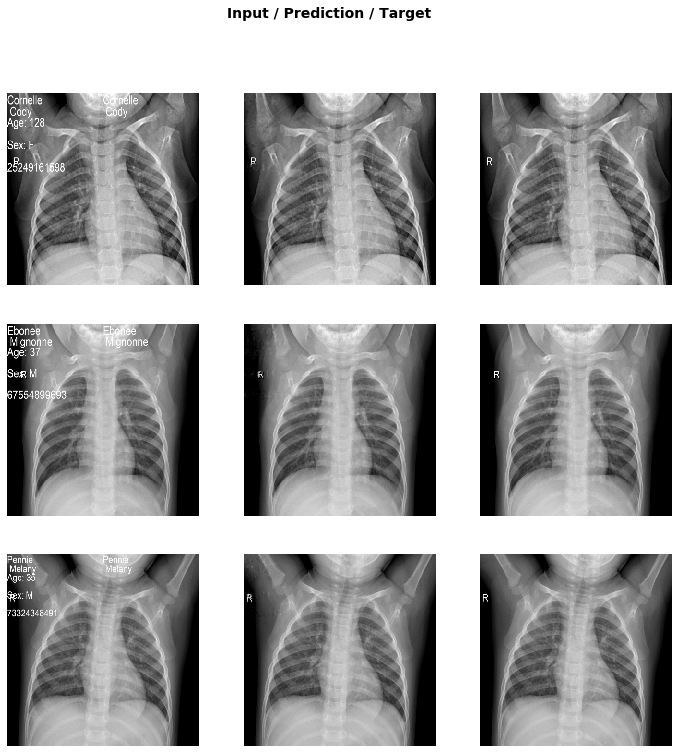

In [40]:
learn.show_results(rows=16)

In [41]:
learn.save('gan-test1')

In [42]:
path_gan_pred = 'gan_pred'
path_gen_gan = path/path_gan_pred
path_gen_gan.mkdir(exist_ok=True)

In [43]:
def save_preds1(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen_gan/names[i].name)
            i += 1

In [44]:
save_preds1(learn.data.fix_dl)

In [99]:
learn_gen = create_gen_learner()

In [100]:
src = ImageImageList.from_folder(path_gen_gan).split_by_rand_pct(0.1, seed=42)

In [101]:
def get_data2(bs,size):
    data = (src.label_from_func(lambda x: path_lr/x.name)
           .transform( size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

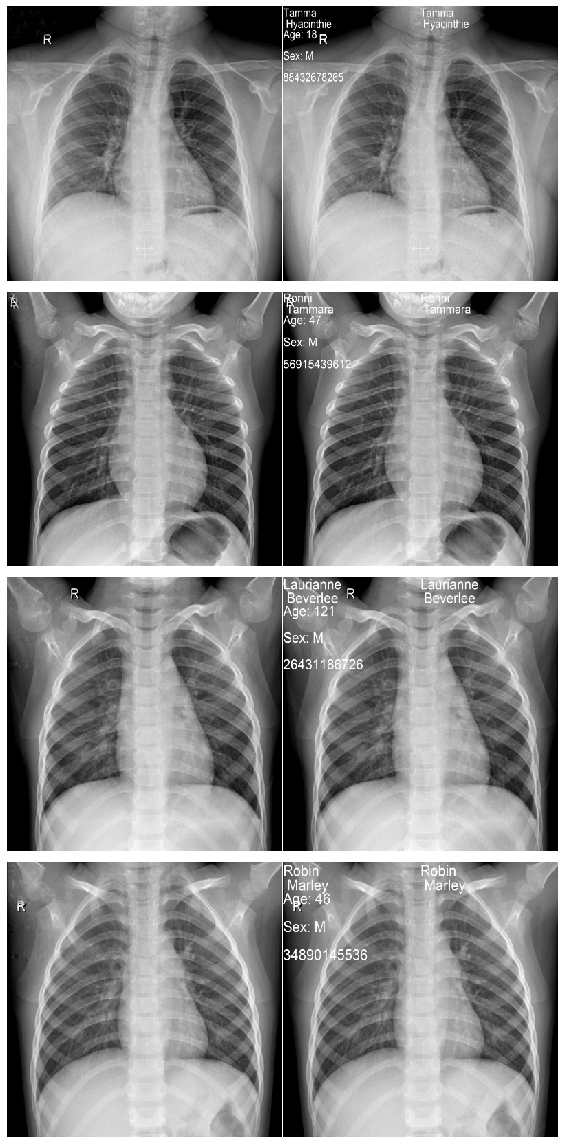

In [102]:
learn_gen.data = get_data2(12,400)
data.show_batch(4)

In [103]:
learn_gen.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-05
Min loss divided by 10: 2.29E-03


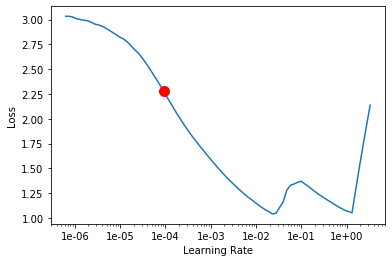

In [104]:
learn_gen.recorder.plot(suggestion=True)

In [105]:
learn_gen.unfreeze()

In [106]:
learn_gen.fit_one_cycle(3, slice(1e-5,1e-2))

In [107]:
learn_gen.save('gan_pred_reverse')

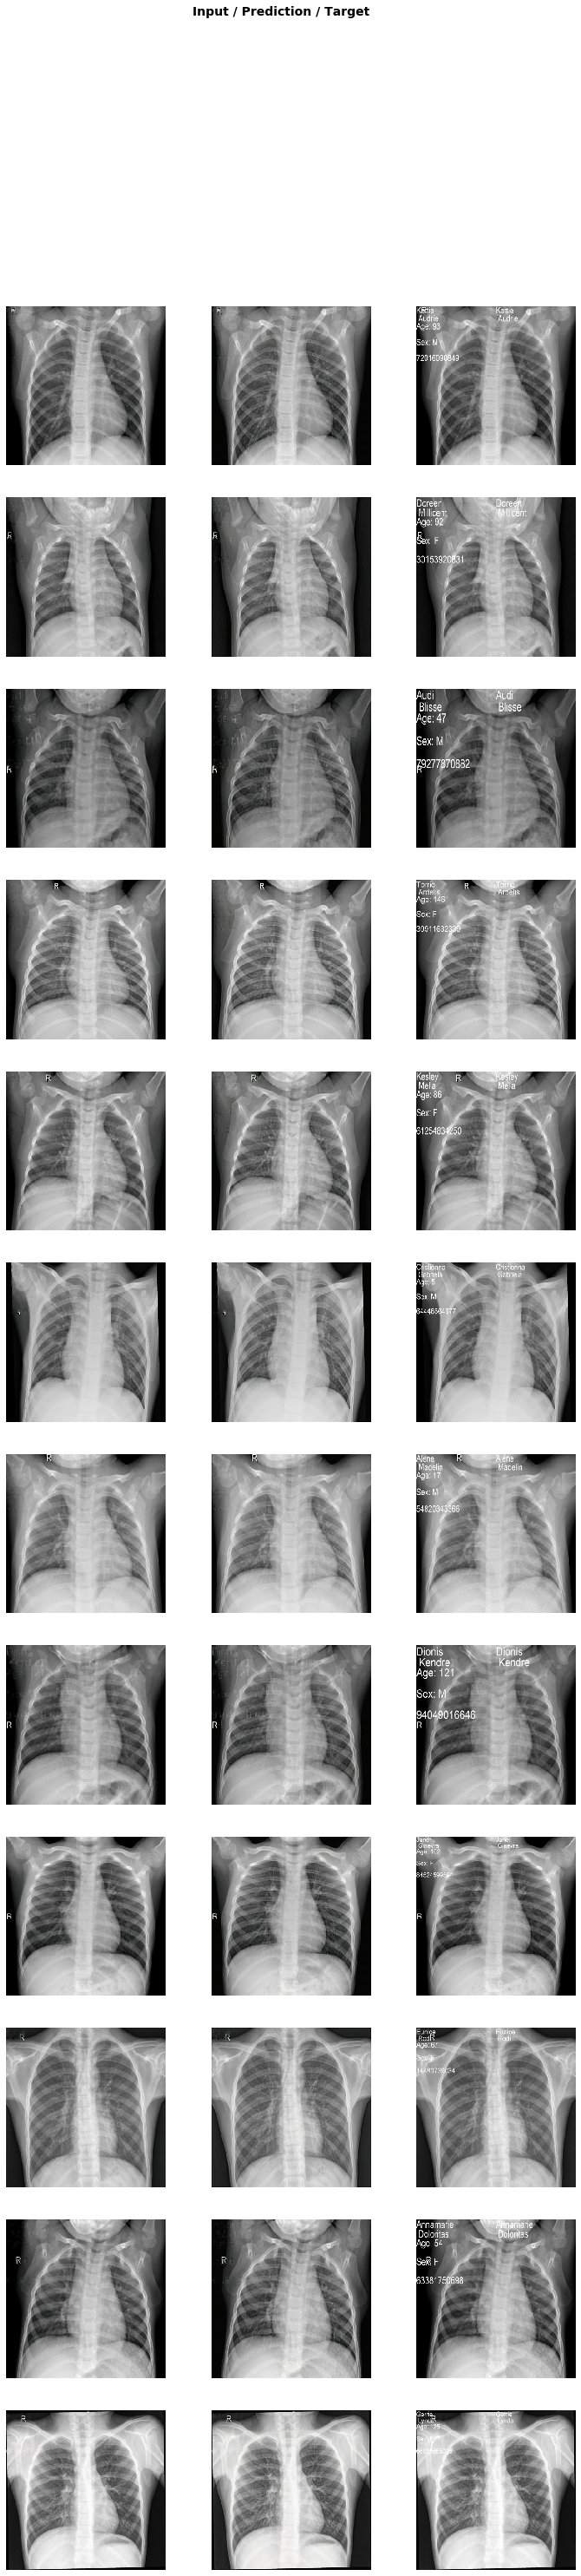

In [108]:
learn_gen.show_results(rows=16)

In [109]:
gan_pred_reverse = 'gan_pred_reverse'
gan_path = path/gan_pred_reverse
gan_path.mkdir(exist_ok=True)

In [110]:
def save_preds_reverse(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(gan_path/names[i].name)
            i += 1

In [111]:
save_preds_reverse(data.fix_dl)